## 1. Library Imports


In [2]:

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
from torch import nn
import torchvision as tv
from torchvision import tv_tensors
from torchvision.io import read_image
from torchinfo import summary
from faster_rcnn_from_scratch.utils import image_visualization as iv
from faster_rcnn_from_scratch.utils import prepare_dataset
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms import v2
from typing import List
from faster_rcnn_from_scratch.utils.anchors import generate_anchor_boxes
from faster_rcnn_from_scratch.utils import iou
# Set seed for reproducibility
torch.manual_seed(36)
device = "cuda" if torch.cuda.is_available() else "cpu"

## 2. Loading an image

- We load a simple Pedestrian Dataset which consists of Pedestrains and Corresponding Masks
- From the masks we generate bboxes


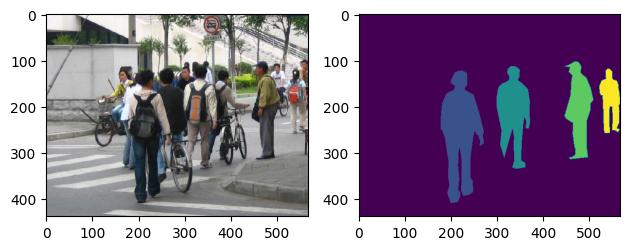

In [3]:
image = read_image("PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image("PennFudanPed/PedMasks/FudanPed00046_mask.png")
image_mask_pair = [image, mask]
figsize = (10, 8)
iv.plot(image_mask_pair)

In [4]:
root = "PennFudanPed"
image_dir = "PNGImages"
mask_dir = "PedMasks"
ds = prepare_dataset.Masks2BboxDs(
    root,
    image_dir,
    mask_dir,
    transforms=v2.Resize(
        (800, 800), interpolation=v2.functional.InterpolationMode.BICUBIC
    ),
)
len(ds)

170

/home/paineni/micromamba/envs/Thesis-env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


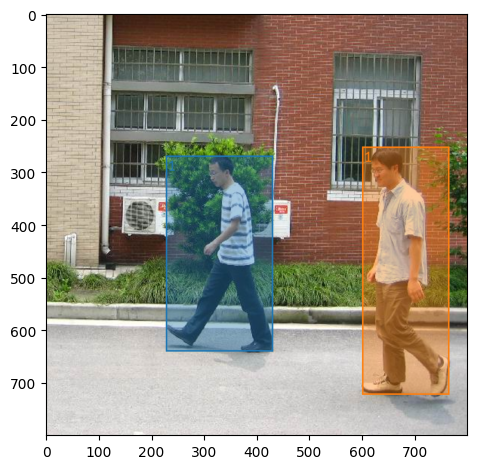

In [5]:
image, target = ds[0]
masks = target["masks"]
gt_labels = target["labels"]
gt_bboxes = target["boxes"]

colors = [mcolors.rgb2hex(plt.get_cmap("tab10")(i)) for i in range(len(masks))]
font = "UbuntuMono-R.ttf"
bbox_image = draw_bounding_boxes(
    image,
    gt_bboxes,
    gt_labels,
    font=font,
    width=3,
    fill=True,
    font_size=30,
    colors=colors,
)
iv.plot(bbox_image)

## 3. Feature Extraction
- We would like to have features to generate anchors
- To generate features we use VGG16


In [6]:
model = tv.models.vgg16(weights=True).to(device)
summary(model, (1, 3, 800, 800))

/home/paineni/micromamba/envs/Thesis-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 25, 25]          --
│    └─Conv2d: 2-1                       [1, 64, 800, 800]         1,792
│    └─ReLU: 2-2                         [1, 64, 800, 800]         --
│    └─Conv2d: 2-3                       [1, 64, 800, 800]         36,928
│    └─ReLU: 2-4                         [1, 64, 800, 800]         --
│    └─MaxPool2d: 2-5                    [1, 64, 400, 400]         --
│    └─Conv2d: 2-6                       [1, 128, 400, 400]        73,856
│    └─ReLU: 2-7                         [1, 128, 400, 400]        --
│    └─Conv2d: 2-8                       [1, 128, 400, 400]        147,584
│    └─ReLU: 2-9                         [1, 128, 400, 400]        --
│    └─MaxPool2d: 2-10                   [1, 128, 200, 200]        --
│    └─Conv2d: 2-11                      [1, 256, 200, 200]        29

In [7]:
model.features[:30]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [8]:
### Collecting layers with output feature map size i.e both width and height of feature map are < 50 (50 is used in the paper)
dummy_img = torch.zeros(
    (1, 3, 800, 800)
).float()  # test image array [1, 3, 800, 800]
print(dummy_img.shape)

req_features = []
k = dummy_img.clone().to(device)
for i in list(model.features[:30]):
    k = i(k)
    req_features.append(i)
    out_channels = k.size()[1]
print(len(req_features))  # 30 # Total features taken are
print(out_channels)  # 512 # Depth of the layer's op

torch.Size([1, 3, 800, 800])
30
512


In [9]:
feature_extractor = nn.Sequential(*req_features).to(device)
image_copy = image.float().to(device).unsqueeze(0)
# Running feature extractor on our image
feature_map = feature_extractor(image_copy)
imgArray = feature_map.data.cpu().squeeze(0)

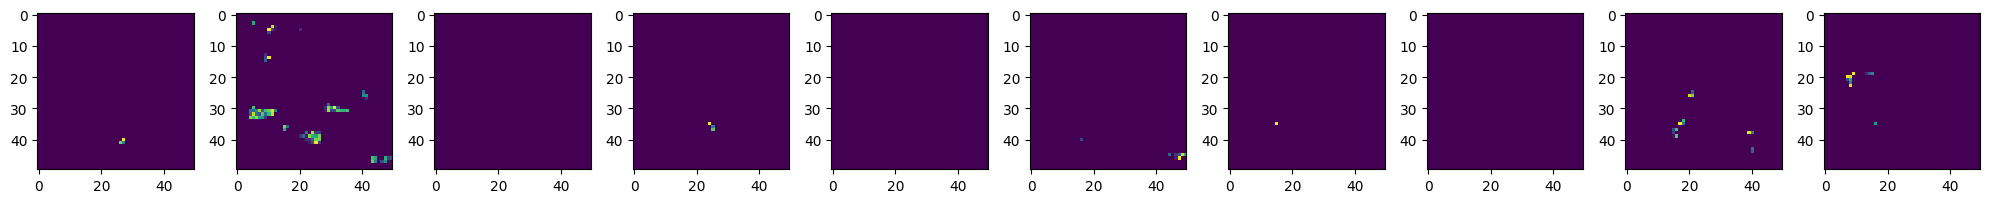

In [10]:
# Visualize few features
num_plots = 10
iv.plot(
    [imgArray[i] for i in range(num_plots)],
    subplots_kwargs={"figsize": (20, 20)},
    subplot_adjust_kwargs={"hspace": 0, "wspace": 0.3},
)

## 4. Generating Anchor Bboxes
- Once we have got the feature map, in our case of size (512,50,50)
- We need Anchors, to generate Anchor Bboxes.
- Anchors are nothing but every pixel of the single channeled feature map (So we have 2500 anchors)
- These pixels are representation of a patch in the original image
- Another interesting bit is since we used VGG16 from beginning to end of final conv stack of VGG, we got 50x50xC feature map, from 800x800x3 image.
  - This conveys one pixel on the map corresponds to 16 by 16 patch on the original image
  - So if you move pixel wise one by one on the feature map, one can imagine a patch of size 16x16 moving correspondingly on the image
  - For this patch on image we will take it's center
- Now to generate Anchor Boxes, we map the anchor points from feature map to the original image
  - On the original image we generate various size bboxes
  - Precisely, for each anchor at the **center** we generate 9 bboxes, each in 3 ratios (small, medium & large) and in 3 shapes (square(surrounding the anchor), 2 rectangles perpendicular to each other)
- Bboxes are generated in following manner:
  - Consider a 16 by 16 patch on original image, calculate it's center
  - This center can be considered as a back-representation of anchor we see on the feature map
  - On this center we generate 9 bboxes as mentioned above, thus for 2500 centres 9 bboxes leading to 22500 bboxes

In [11]:
feature_map_size = 50  # Size of the feature map (example value)
window_size = (
    800 // feature_map_size
)  # The stride of the sliding window or feature map stride
aspect_ratios = [0.5, 1, 2]
scales = [8, 16, 32]

anchor_bboxes = generate_anchor_boxes(
    feature_map_size, window_size, aspect_ratios, scales
)
print(anchor_bboxes.shape)  # (22500, 4)

(22500, 4)


 ### Visualize the anchor boxes on the image


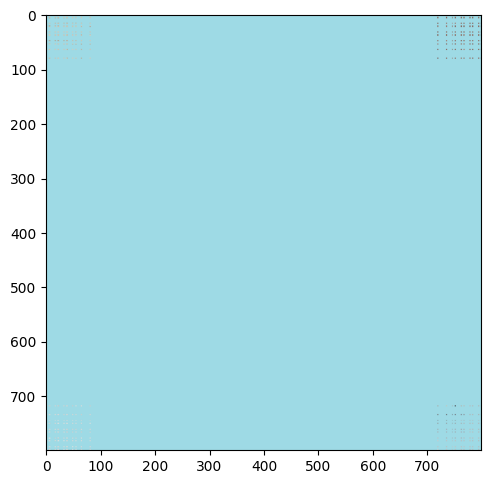

In [12]:
torch_bboxes = tv_tensors.BoundingBoxes(
    anchor_bboxes, format="XYXY", canvas_size=v2.functional.get_size(image)
)

colors = [
    mcolors.rgb2hex(plt.get_cmap("tab20")(i)) for i in range(len(torch_bboxes))
]
font = "UbuntuMono-R.ttf"
bbox_image = draw_bounding_boxes(
    image,
    torch_bboxes,
    font=font,
    width=3,
    fill=False,
    font_size=30,
    colors=colors,
)
iv.plot(bbox_image, subplots_kwargs={"figsize": (5, 5)})

 ### Validating the Anchor Bboxes

- We remove the bboxes who go out of the condition i.e. xmin, ymin being < 0 and xmax,ymax being > 800


In [13]:
valid_indices = np.where(
    (anchor_bboxes[:, 0] >= 0)
    & (anchor_bboxes[:, 1] >= 0)
    & (anchor_bboxes[:, 2] <= 800)
    & (anchor_bboxes[:, 3] <= 800)
)[0]
valid_boxes = anchor_bboxes[valid_indices]
print(type(valid_boxes), (valid_boxes.shape))

<class 'numpy.ndarray'> (8940, 4)


### Note
- Once we have generated all the anchor boxes, we need to look at the objects inside the image and assign them to the specific anchor boxes which contain them. Faster-R-CNN has some guidelines to assign labels to the anchor boxes
- We assign a positive label(1 or can be any int >=1 depending on different object categories) to 2 kind of anchor boxes:
  - All the anchor boxes with the highest IoU overlap with gt-box or
  - The anchor box that has an IoU overlap higher than 0.7 with gt-box
    - Basically finding out which gt has highest overlap with an anchor box
    - Later verifying if that IoU is greater than 0.7 or not
  - With these conditions a single gt may assign positive labels to multiple anchor boxes
- We assign a negative label(0) to a anchor box if it's IoU ratio is lower than 0.3 for all gt-boxes
- **Anchor boxes which are neither positive nor negative do not contribute to the training objective**
- For training a RPN we use only 1 and 0 as labels where 1 represents there is an object and 0 means background

In [14]:
# Create a label array of length valid anchor boxes and fill it with -1
valid_labels = np.empty((len(valid_boxes)), dtype=np.int8)
valid_labels.fill(-1)

print(valid_labels.shape)

(8940,)


In [15]:
valid_boxes_tensor = tv_tensors.BoundingBoxes(
    valid_boxes, format="XYXY", canvas_size=v2.functional.get_size(image)
)

In [16]:
# for each valid anchor box calculate the IoU with each gt object.
# Since we have 8940 anchor boxes and 2 gt_objects, we should get an array of
# (8940,2) where each collumn depicts whether anchor bbox is +ve or not

# Complete box iou function takes cross product kind of calculation, while the
# simple box_iou takes dot product kind of calculation, calculating iou's only in between corresponding bboxes in 2 arrays

input_boxes = valid_boxes_tensor.data

gt_boxes = gt_bboxes.data

valid_bbox_ious = iou.calculate_iou(input_boxes, gt_boxes)
print("IoU Matrix:")
print(valid_bbox_ious)

# Flatten the IoU matrix and create a DataFrame
num_input_boxes = input_boxes.shape[0]
num_gt_boxes = gt_boxes.shape[0]
data = []
for i in range(num_input_boxes):
    for j in range(num_gt_boxes):
        data.append([i, j, valid_bbox_ious[i, j].item()])

df = pd.DataFrame(data, columns=["input_box_index", "gt_box_index", "iou"])

# Save to CSV
df.to_csv("iou_values.csv", index=False)

IoU Matrix:
tensor([[0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        ...,
        [0.0000, 0.1173],
        [0.0000, 0.1036],
        [0.0000, 0.0901]], dtype=torch.float64)


- Assign positive label if:
    - Find highest IoU value with each gt, and all the anchor bboxes that yields the highest IoU
      - Here it might happen that more than 2 anchors come for 1 gt, and this is fine,
        as this is highest IoU value from perspective of GT
    - Find each anchor boxes, highest IoU giving GT
      - From these indexes select only the one's having IoU > 0.7 threshold
      - The reason for doing this is to minimize the search space.
      - If we directly use threshold, then it can happen that more than one anchor box is available to 1 gt,
        and we would want to avoid this scenario from perspective of Anchor Box
  - Assign negative label if:
    - IoU is lower than 0.3 for **all gt's**
  - If not positive, nor -ve then ignore

### Case-I Finding argmax iou

In [17]:
# NOTE: Simply doing argmax and collecting that anchor might not be enough because argmax only gives first occurence of highest element as in above example

# index of anchors having highest iou's with gt's
gt_argmax_ious = valid_bbox_ious.argmax(axis=0)  # Column wise
# iou values at these argmax index
gt_max_ious = valid_bbox_ious[
    gt_argmax_ious, [0, 1]
]  # Select 0th column in first row and 1st column in the second row


# get all the indexes of anchors having these high value of iou's with gt
gt_max_iou_anchors_index = np.where(valid_bbox_ious == gt_max_ious)[0]
# (array([3331, 8535]), array([0, 1]))
# This means element at (3331,0) and (8535,1) correspond to the gt_max_ious
# If there could have been more anchors yielding the same highest gt_max_iou
# values, then we could have more than 2 indices, i.e. more than 2 anchors

print(gt_argmax_ious, gt_max_ious, gt_max_iou_anchors_index)

tensor([3331, 8523]) tensor([0.8677, 0.7150], dtype=torch.float64) [3331 8523 8527 8531 8535 8539 8543 8547]


#### Case-II: Finding GT for which Anchor yields a high value


In [18]:
# Index of Gt's for which an anchor gives high IoU as compare to other Gt's
anchor_argmax_ious = valid_bbox_ious.argmax(axis=1)

# Getting the max iou values
anchor_max_ious = valid_bbox_ious[
    np.arange(len(valid_boxes)), anchor_argmax_ious
]


print(anchor_argmax_ious.shape, anchor_max_ious.shape)

torch.Size([8940]) torch.Size([8940])


### Filling of labels

In [19]:
pos_iou_threshold = 0.7
neg_iou_threshold = 0.3
# - Assign negative label (0) to all the anchor boxes which have max_iou less than negative threshold
# NOTE: Finding the max of 2 anchors, decreased the search space as now we only need to compare the max anchors
valid_labels[anchor_max_ious < neg_iou_threshold] = 0
# Assign positive label (1) to all the anchor boxes which have Highest IoU overlap with gt-bbox
# Assign positive label (1) to all the anchor boxes which have max_iou greater than pos_threshold
valid_labels[gt_argmax_ious] = 1
valid_labels[anchor_max_ious >= pos_iou_threshold] = 1

In [20]:
nta = np.where(valid_labels == -1)
print(f"We will ignore these many samples from RPN {nta[0].shape} training")


nta = np.where((valid_labels == 0))
print(
    f"We will include these many -ve samples from RPN {nta[0].shape} training"
)
nta = np.where((valid_labels == 1))
print(
    f"We will include these many +ve samples from RPN {nta[0].shape} training"
)

We will ignore these many samples from RPN (758,) training
We will include these many -ve samples from RPN (8159,) training
We will include these many +ve samples from RPN (23,) training


## 5. Generating Target Anchor Bboxes for Training RPN

- We are sampling from the above filtered bboxes which are near to the GT's and chosen from all bboxes above which generated +ve and -ve IoU value with GT
- Once we have labels, we only use some of them for training RPN
- Each mini-batch arises from a single image that contains many positive and negitive example anchor bboxes, but this will bias towards negitive samples as they dominate
- Instead, we randomly sample 256 anchor bboxes in an image to compute the loss function of a mini-batch, where the sampled positive and negative anchors have a ratio of up to 1:1
- If there are fewer than 128 positive samples in an image, we pad the mini-batch with negative ones


In [21]:
pos_ratio = 0.5
n_sample = 256


# Total Positive Samples
n_pos = pos_ratio * n_sample

- Ramdomly sample n_pos samples from the positive labels and ignore(-1) the remaining ones.
- If the pos samples are less than 128 we fill the remaining ones with -ve samples (0) and ignore the rest

In [22]:
n_neg = n_sample * np.sum(valid_labels == 1)
n_neg

5888

In [23]:
pos_index = np.where(valid_labels == 1)[0]
if len(pos_index) > n_pos:
    # Randomly sample indices to not use in the training
    disable_index = np.random.choice(
        pos_index, size=(len(pos_index) - n_pos), replace=False
    )
    valid_labels[disable_index] = -1
    # Negative Samples
n_neg = n_sample * np.sum(valid_labels == 1)
neg_index = np.where(valid_labels == 0)[0]
if len(neg_index) > n_neg:
    disable_index = np.random.choice(
        neg_index, size=(len(neg_index) - n_neg), replace=False
    )
    valid_labels[disable_index] = -1

In [24]:
nta = np.where(valid_labels == -1)
print(f"We will ignore these many samples from RPN {nta[0].shape} training")


nta = np.where((valid_labels == 0))
print(
    f"We will include these many -ve samples from RPN {nta[0].shape} training"
)
nta = np.where((valid_labels == 1))
print(
    f"We will include these many +ve samples from RPN {nta[0].shape} training"
)

We will ignore these many samples from RPN (3029,) training
We will include these many -ve samples from RPN (5888,) training
We will include these many +ve samples from RPN (23,) training


### Getting the difference between anchor bboxes and Gt's
- Here we find the differneces between sampled anchor boxes and Gt's and make the RPN learn these diferences
- We select which ever gt has high iou with that anchor box.
- NOTE: We will assign anchor locs to all valid anchor boxes, irrespective of its label.
- Later when we calculate the losses, we can remove the irrelevant anchor boxes.
Thes differences are calculated as follows:
    - $t_{x} = (x-x_{a})/w_{a}$
    - $t_{y} = (y - y_{a})/h_{a}$
    - $t_{w} = log(w/ w_{a})$
    - $t_{h} = log(h/ h_{a})$
    - $x,y,w,h are the gt box center coordinates, width and height
    - $x_{a},y_{a},w_{a},h_{a}$ are represent centre coordinates and width and height of anchor boxes
    


In [25]:
anchor_argmax_ious.shape

torch.Size([8940])

In [26]:
# For each anchor box we select the gt that has max iou with the anchor box
# The elements will be 8940 itself, we just return the index of gt that has highest overlap with that anchor box
max_iou_bbox = gt_bboxes[anchor_argmax_ious]
print(max_iou_bbox.shape)
print(max_iou_bbox)

torch.Size([8940, 4])
tensor([[227.5492, 270.1492, 430.7693, 641.7910],
        [227.5492, 270.1492, 430.7693, 641.7910],
        [227.5492, 270.1492, 430.7693, 641.7910],
        ...,
        [599.6423, 253.7313, 764.2219, 723.8806],
        [599.6423, 253.7313, 764.2219, 723.8806],
        [599.6423, 253.7313, 764.2219, 723.8806]])


In [27]:
# NOTE; Before we proceed further we need to convert xyxy bbox format of our anchor boxes and gt boxes to xywh.
height = valid_boxes[:, 2] - valid_boxes[:, 0]
width = valid_boxes[:, 3] - valid_boxes[:, 1]
ctr_y = valid_boxes[:, 0] + 0.5 * height
ctr_x = valid_boxes[:, 1] + 0.5 * width


base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_ctr_y = max_iou_bbox[:, 0] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 1] + 0.5 * base_width

In [28]:
# Getting the Anchor Locations with above formulaes
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)
dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)
anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(anchor_locs)

[[ 3.01801174  1.9443786   0.80883269  0.71932659]
 [ 3.01801174  1.85599025  0.80883269  0.71932659]
 [ 3.01801174  1.76760191  0.80883269  0.71932659]
 ...
 [-0.68576025 -0.96781943  0.59793761  0.9544463 ]
 [-0.68576025 -1.05620778  0.59793761  0.9544463 ]
 [-0.68576025 -1.14459613  0.59793761  0.9544463 ]]


### Mapping the locations and labels to the whole Anchors (22500) and Labels

In [29]:
# Final Labels
anchor_labels = np.empty((len(anchor_bboxes),), dtype=valid_labels.dtype)
anchor_labels.fill(-1)
anchor_labels[valid_indices] = valid_labels

In [30]:
nta = np.where(anchor_labels == -1)
print(f"We will ignore these many samples from RPN {nta[0].shape} training")


nta = np.where((anchor_labels == 0))
print(
    f"We will include these many -ve samples from RPN {nta[0].shape} training"
)
nta = np.where((anchor_labels == 1))
print(
    f"We will include these many +ve samples from RPN {nta[0].shape} training"
)

We will ignore these many samples from RPN (16589,) training
We will include these many -ve samples from RPN (5888,) training
We will include these many +ve samples from RPN (23,) training


In [31]:
# Final Anchors
anchor_locations = np.empty(
    (len(anchor_bboxes),) + anchor_bboxes.shape[1:], dtype=anchor_locs.dtype
)
anchor_locations.fill(0)
# Assigning the filtered anchor bboxes, with the translated bboxes
anchor_locations[valid_indices, :] = anchor_locs

In [32]:
print(anchor_labels.shape, anchor_locations.shape)

(22500,) (22500, 4)


### **These labels and Anchors (with valid labels) will be used as targets to the RPN network.**

## 6. Region Proposal Network

<img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*rQ99lLIs7xTAjTaKHHNatA.png" alt="Image" style="height:300px; width:600px; align:center">

- Prior to this work, region proposals for a network were generated using selective search, CPMC, MCG, Edgeboxes etc. Faster_R-CNN is the first work to demonstrate generating region proposals using deep learning.
- The network contains a convolution module, on top of which there will be one regression layer, **which predicts the location of the box inside the anchor**
- To generate region proposals, we slide a small network over the feature map op.
  - This small network takes as input an nxn spatial window of the ip feature map
  - Each sliding window is mapped to a lower dimensional feature (Basically conv operation)
  - The op of the small conv network is fed to 2 FC layers:
    - A box regression layer
    - A box classification layer

In [33]:
# We use n = 3, as Faster-RCNN paper. We can any other value of n as well.
mid_channels = 512
in_channels = 512  # NOTE: Dependent on the feature map given by the backbone, for VGG16 it's 512
n_anchor_boxes = 9  # Number of anchor boxes at each anchor point

In [34]:
conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(device)
reg_layer = nn.Conv2d(mid_channels, n_anchor_boxes * 4, 1, 1, 0).to(device)
cls_layer = nn.Conv2d(mid_channels, n_anchor_boxes * 2, 1, 1, 0).to(
    device
)  ## I will be going to use softmax here. you can equally use sigmoid if u replace 2 with 1.


# Initial Initialization as per the paper
# conv sliding layer
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()
# Regression layer
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()
# classification layer
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

# Sending the ops from feature extraction state to this network to predict location of objects wrt anchor and the objectness score associated with it
x = conv1(feature_map)  # Feature Map Obtained in Sec 3
pred_anchor_locs = reg_layer(x)
# NOTE Anchor locs are the anchor bboxes and Not  the translated locations.
# So the network will try to learn such anchor bboxes, who are very similar to the translated anchor bboxes we generated above.
# N these predicted anchor bboxes will have ideally max ious with GT.
pred_cls_scores = cls_layer(x)
print(pred_cls_scores.shape, pred_anchor_locs.shape)

torch.Size([1, 18, 50, 50]) torch.Size([1, 36, 50, 50])


### Reformatting the outputs


In [35]:
pred_anchor_locs = (
    pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
)
print(pred_anchor_locs.shape)
# [1, 36(9*4), 50, 50] => [1, 22500(50*50*9), 4] (dy, dx, dh, dw)
# Out: torch.Size([1, 22500, 4])
pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)
# Out torch.Size([1, 50, 50, 18])
# [1, 18(9*2), 50, 50] => [1, 22500, 2]  (1, 0)
objectness_score = (
    pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1]
    .contiguous()
    .view(1, -1)
)
print(objectness_score.shape)
# Out torch.Size([1, 22500])
pred_cls_scores = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)
# Out torch.size([1, 22500, 2])

torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])


- pred_cls_scores and pred_anchor_locs are the output the RPN network and are used to calculate the losses to updates the weights of the network
- pred_cls_scores(labels) and objectness_scores(coordinates) are used as inputs to the proposal layer, which generate a set of proposal which are further used by RoI network. We will see this in the next section.

In [36]:
print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)
print(anchor_locations.shape)
print(anchor_labels.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
(22500, 4)
(22500,)


In [37]:
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

print(rpn_loc.shape, rpn_score.shape, gt_rpn_loc.shape, gt_rpn_score.shape)

torch.Size([22500, 4]) torch.Size([22500, 2]) torch.Size([22500, 4]) torch.Size([22500])


In [38]:
# For classification we use cross-entropy loss
rpn_cls_loss = nn.functional.cross_entropy(
    rpn_score, gt_rpn_score.long().to(device), ignore_index=-1
)
print(rpn_cls_loss)

tensor(1.1750, device='cuda:0', grad_fn=<NllLossBackward0>)


In [39]:
# For Regression we use smooth L1 loss as defined in the Fast RCNN paper
pos = gt_rpn_score > 0  # Considering positive samples
mask = pos.unsqueeze(1).expand_as(rpn_loc)
print(mask.shape)

# take those bounding boxes which have positve labels
mask_loc_preds = rpn_loc[mask].view(-1, 4)
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1).float() * 0.5 * x**2) + ((x >= 1).float() * (x - 0.5))
print(rpn_loc_loss.sum())

torch.Size([22500, 4])
torch.Size([23, 4]) torch.Size([23, 4])
tensor(98.0897, dtype=torch.float64, grad_fn=<SumBackward0>)


## 7. Generating Proposals from RPN to feed Fast R-CNN network

- The proposal function will take the following parameters
  - training_mode or testing_mode
  - nms_thresh
  - n_train_pre_nms: Number of bboxes before nms during training
  - n_train_post_nms: Number of bboxes after nms during training
  - n_test_pre_nms: Number of bboxes before nms during testing
  - n_test_post_nms: Number of bboxes after nms during testing
  - min_size: Minimum height of the object required to create a proposal

- The Faster R_CNN says, RPN proposals highly overlap with each other.
- To reduced redundancy, we adopt non-maximum supression (NMS) on the proposal regions based on their cls scores.
- We fix the IoU threshold for NMS at 0.7, which leaves us about 2000 proposal regions per image.
- After an ablation study, the authors show that NMS does not harm the ultimate detection accuracy, but substantially reduces the number of proposals.
- After NMS, we use the top-N ranked proposal regions for detection. In the following we training Fast R-CNN using 2000 RPN proposals.
- During testing they evaluate only 300 proposals, they have tested this with various numbers and obtained this.


In [40]:
nms_thresh = 0.7
n_train_pre_nms = 12000
n_train_post_nms = 2000
n_test_pre_nms = 6000
n_test_post_nms = 300
min_size = 16

- To generate region proposals to the network following steps will be followed
  - Convert the loc (anchor location) predictions from the rpn network to bbox [y1,x1,y2,x2]
  - Clip the predicted boxes to the image
  - Remove predicted boxes with either height or width < threshold (minsize)
  - Sort all (proposal, score) pairs by score from highest to lowest
  - Take top pre_nms_topN (e.g. 12000 while training and 300 while testing)
  - Apply nms threshold > 0.7
  - Take top pos_nms_topN (eg. 2000 while training and 300 while testing)

### Converting the Anchor Location Predictions to BBox

- This operation is reverse operation of what we did while assigning gt to anchor boxes.
- This operation decodes predictions by unparameterizing them and offseting to image.
  - #ctr is for center
  - $x = (w_{a} * ctr_{xp}) + ctr_{xa}$
  - y = $(h_{a} * ctr_{xp}) + ctr_{xa}$
  - $h = np.exp(h_{p}) * h_{a}$
  - $w = np.exp(w_{p}) * w_{a}$


#### Convert anchors bbox format from y1, x1, y2, x2 to ctr_x, ctr_y, h,2

In [41]:
anc_height = anchor_bboxes[:, 2] - anchor_bboxes[:, 0]
anc_width = anchor_bboxes[:, 3] - anchor_bboxes[:, 1]
anc_ctr_y = anchor_bboxes[:, 0] + 0.5 * anc_height
anc_ctr_x = anchor_bboxes[:, 1] + 0.5 * anc_width
print(anc_ctr_x.shape, anc_ctr_y.shape)

(22500,) (22500,)


#### Convert prediction locations using above formulas, before doing this don't forget to get data in np array

In [42]:
pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()
dy = pred_anchor_locs_numpy[:, 0::4]
dx = pred_anchor_locs_numpy[:, 1::4]
dh = pred_anchor_locs_numpy[:, 2::4]
dw = pred_anchor_locs_numpy[:, 3::4]
ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]

print(dy.shape, w.shape)

(22500, 1) (22500, 1)


#### Convert [ctr_x, ctr_y, h, w] to [y1, x1, y2, x2]

In [43]:
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)
roi[:, 0::4] = ctr_y - 0.5 * h
roi[:, 1::4] = ctr_x - 0.5 * w
roi[:, 2::4] = ctr_y + 0.5 * h
roi[:, 3::4] = ctr_x + 0.5 * w
print(roi.shape)

(22500, 4)


### CLIP the predicted boxes to the image

In [44]:
img_size = (800, 800)  # Image size
# Clip the y coordinates to 0 to 800
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[1])
# Clip the x coordinates to 0 to 800
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[0])
print(roi.shape, np.max(roi), np.min(roi))

(22500, 4) 800.0 0.0


### Remove predicted boxes with either height or width < threshold

In [45]:
hs = roi[:, 2] - roi[:, 0]
ws = roi[:, 3] - roi[:, 1]
keep = np.where((hs >= min_size) & (ws >= min_size))[0]
roi = roi[keep, :]
score = objectness_score_numpy[keep]
print(keep.shape, roi.shape, score.shape)
# Out:
##(22500, ) all the boxes have minimum size of 16

(12651,) (12651, 4) (12651,)


### Sort all (proposal, score) pairs by the score from highest to lowest

In [46]:
order = score.ravel().argsort()[::-1]
print(order.shape)

(12651,)


### Take the top pre_nms_topN

In [47]:
# Take top pre_nms_topN (e.g. 12000 while training and 300 while testing)
order = order[:n_train_pre_nms]
roi = roi[order, :]
print(roi.shape)
print(roi)

(12000, 4)
[[  0.         118.9095459  672.98841858 800.        ]
 [634.36299896 370.50517273 775.28928375 673.69374084]
 [581.10604858 476.53627777 800.         572.98090363]
 ...
 [223.56025941 194.17197541 445.56228996 291.71835714]
 [662.60642624   0.         703.0929451  385.52393341]
 [574.74770806   0.         800.         581.80000614]]


### Apply NMS
- Overlapping bboxes are merged

In [48]:
y1 = roi[:, 0]
x1 = roi[:, 1]
y2 = roi[:, 2]
x2 = roi[:, 3]

areas = (x2 - x1 + 1) * (y2 - y1 + 1)
order = order.argsort()[::-1]
keep = []
while order.size > 0:
    i = order[0]  # take the 1st elementt in order and append to keep
    keep.append(i)
    xx1 = np.maximum(x1[i], x1[order[1:]])
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]])
    w = np.maximum(0.0, xx2 - xx1 + 1)
    h = np.maximum(0.0, yy2 - yy1 + 1)
    inter = w * h
    ovr = inter / (areas[i] + areas[order[1:]] - inter)
    inds = np.where(ovr <= nms_thresh)[0]
    order = order[inds + 1]

keep = keep[:n_train_post_nms]  # while training/testing , use accordingly
roi = roi[keep]  # the final region proposals
print(len(keep), roi.shape)

2000 (2000, 4)


## 8. Generating Proposal Targets

#### NOTE

- The final region proposals were obtained.
  - These will be used as the ip to the Fast-RCNN object which finally tries to predict the object locations (with respect to the proposesd box)
  - Also it tries to predict the class of the object (classification of each proposal)
- Before feeding the proposals to the Fast-RCNN:
  - We need to first create targets for these proposals for training the network
- Once we have both targets and proposals:
  - We pass proposals to the network
  - Obtain the predicted Ops
  - Determine the losses

- The Fast R-CNN network takes the region proposals (obtained from proposal layer in previous section), ground truth boxes and their respective labels as inputs.
- It will take the following parameters:
  - n_sample: Number of samples to sample from roi, The default value is 128.
  - pos_ratio: the number of positive examples out of the n_samples. The default values is 0.25.
  - pos_iou_thresh: The minimum overlap of region proposal with any groundtruth object to consider it as positive label.
  - [neg_iou_threshold_lo, neg_iou_threshold_hi] : [0.0, 0.5], The overlap value bounding required to consider a region proposal as negitive [background object].

In [49]:
n_sample = 128
pos_ratio = 0.25
pos_iou_thresh = 0.5
neg_iou_thresh_hi = 0.5
neg_iou_thresh_lo = 0.0

- Following steps are used to generate the proposal targets

  - For each roi, find the IoU with all other gt object ([N,n])
    - N: Number of Region Proposals
    - n: Number of gt boxes
  - Find which gt object has highest iou with the roi [N]
    - These gt's labels will be the labels for each and every region proposal
  - If the highest IoU is greater than pos_iou_thresh, then we assign the label of gt
    - Pos_Samples_Collection:
      - We randomly sample [n_sample x pos_ratio] region proposals and consider only these as positive labels
  - If the IoU is between [0.1, 0.5], we assign a negative label(0) to the region proposal

    - Neg_Samples_Collection:
      - We randomly sample [128 - number of pos region proposals on this image] and assign 0 to these region proposals

  - We collect the pos samples and neg_samples and remove all other region proposals
  - Lastly we convert the locations of gt objects for each region proposal to the required format (As required by Fast R-CNN)
  - Output labels and locations for the samples ROIs (i.e. the targets)

In [50]:
roi_tensor = tv_tensors.BoundingBoxes(
    roi, format="XYXY", canvas_size=v2.functional.get_size(image)
)

In [51]:
# Finding the IoU of gt_object with region proposals
target_region_proposal_ious = iou.calculate_iou(
    roi_tensor.data, gt_bboxes.data
)
print(target_region_proposal_ious.shape)

torch.Size([2000, 2])


In [52]:
# Find out which ground truth has high IoU for each region proposal, Also find the maximum IoU
gt_assignment = target_region_proposal_ious.argmax(axis=1)
max_iou = target_region_proposal_ious.max(axis=1)
print(gt_assignment)
print(max_iou)

# Assign the labels to each proposal
gt_labels = np.array(gt_labels)
gt_roi_label = gt_labels[gt_assignment]
print(gt_roi_label)

# Note: Incase if u have not taken the background object as 0, add +1 to all the labels.

tensor([1, 1, 1,  ..., 1, 0, 0])
torch.return_types.max(
values=tensor([0.0313, 0.0088, 0.4374,  ..., 0.2147, 0.0806, 0.0388],
       dtype=torch.float64),
indices=tensor([1, 1, 1,  ..., 1, 0, 0]))
['1' '1' '1' ... '1' '1' '1']


In [53]:
# Select the foreground rois as per the pos_iou_thesh and
# n_sample x pos_ratio (128 x 0.25 = 32) foreground samples.
pos_roi_per_image = 32
pos_index = np.where(max_iou.values >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))
if pos_index.size > 0:
    pos_index = np.random.choice(
        pos_index, size=pos_roi_per_this_image, replace=False
    )
print(pos_roi_per_this_image)
print(pos_index)

# Similarly we do for negitive (background) region proposals
neg_index = np.where(
    (max_iou.values < neg_iou_thresh_hi)
    & (max_iou.values >= neg_iou_thresh_lo)
)[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))
if neg_index.size > 0:
    neg_index = np.random.choice(
        neg_index, size=neg_roi_per_this_image, replace=False
    )
print(neg_roi_per_this_image)
print(neg_index)

11
[ 791  445 1021  351 1421 1449  458  360  160  643  500]
117
[1048  409 1824 1254 1742 1358  603 1318   93 1990 1716 1151 1863 1731
 1081 1815  108 1675 1004 1710  209  501 1629  789 1911 1639 1643  236
  297  575  254 1024 1724 1768  401 1001  986 1593   19 1027  486  189
 1801  381 1866 1414 1516  562  493  403  173  942 1489  585  826 1609
  705 1935    7 1309  366 1154  834 1656   99 1270 1628 1056 1579 1038
  652  329 1697  935  692 1346  646 1093 1337 1268 1331 1109 1744 1231
 1288  628  632  223 1274  577  553 1726   85 1723 1981 1749  433  118
 1762  729 1284  259 1213  426  615  817 1606  633 1158 1831 1920  597
 1117  956 1359 1229 1974]


### Displaying +ve and -ve samples

In [54]:
roi_imgs = []
roi_bboxes = []
pos_labels = []
for i in range(pos_roi_per_this_image):
    roi_bbox = roi[pos_index[i]].astype(int)
    roi_bboxes.append(roi_bbox)
    pos_labels.append(gt_roi_label[pos_index[i]].astype(str))

torch_bboxes = tv_tensors.BoundingBoxes(
    roi_bboxes, format="XYXY", canvas_size=v2.functional.get_size(image)
)
colors = [
    mcolors.rgb2hex(plt.get_cmap("tab20")(i)) for i in range(len(torch_bboxes))
]
font = "UbuntuMono-R.ttf"
positive_samples_bbox_img = draw_bounding_boxes(
    image,
    torch_bboxes,
    font=font,
    width=3,
    fill=False,
    font_size=30,
    labels=pos_labels,
    colors=colors,
)

roi_imgs = []
roi_bboxes = []
neg_label = []
for i in range(neg_roi_per_this_image):
    roi_bbox = roi[neg_index[i]].astype(int)
    roi_bboxes.append(roi_bbox)
    neg_label.append(gt_roi_label[neg_index[i]].astype(str))
torch_bboxes = tv_tensors.BoundingBoxes(
    roi_bboxes, format="XYXY", canvas_size=v2.functional.get_size(image)
)
colors = [
    mcolors.rgb2hex(plt.get_cmap("tab20")(i)) for i in range(len(torch_bboxes))
]
font = "UbuntuMono-R.ttf"
negative_samples_bbox_img = draw_bounding_boxes(
    image,
    torch_bboxes,
    font=font,
    width=3,
    fill=False,
    font_size=30,
    labels=neg_label,
    colors=colors,
)

/home/paineni/micromamba/envs/Thesis-env/lib/python3.11/site-packages/torchvision/tv_tensors/_tv_tensor.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.as_tensor(data, dtype=dtype, device=device).requires_grad_(requires_grad)


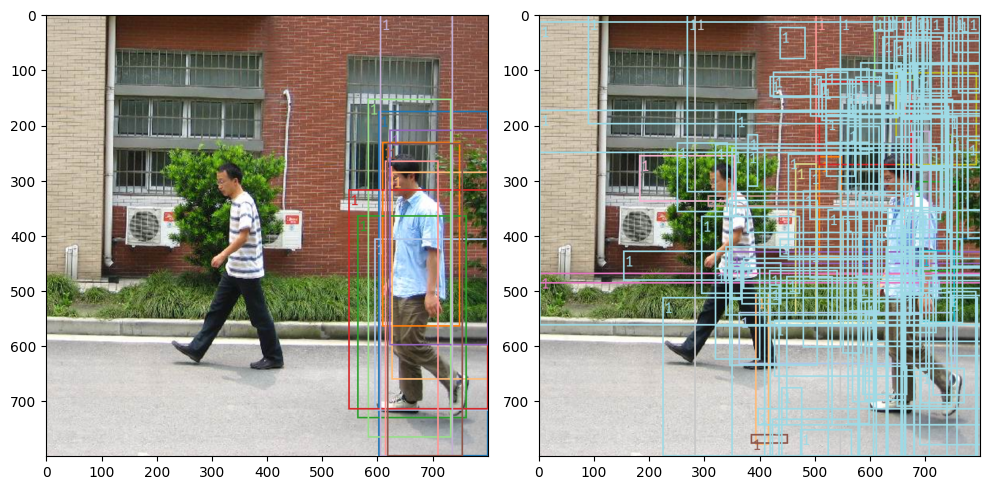

In [55]:
iv.plot(
    [positive_samples_bbox_img, negative_samples_bbox_img],
    subplots_kwargs={"figsize": (10, 10)},
)

In [56]:
# Now we gather positive sample index and negative sample index, their respective labels and region proposals
keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0  # negative labels --> 0
sample_roi = roi[keep_index]
print(sample_roi.shape)


# Pick the gt objects for these sample_roi and later parameterize as we have done while assigning locations to anchor boxes in section 5.
bbox_for_sampled_roi = gt_bboxes[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)

height = sample_roi[:, 2] - sample_roi[:, 0]
width = sample_roi[:, 3] - sample_roi[:, 1]
ctr_y = sample_roi[:, 0] + 0.5 * height
ctr_x = sample_roi[:, 1] + 0.5 * width

base_height = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_width = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_y = bbox_for_sampled_roi[:, 0] + 0.5 * base_height
base_ctr_x = bbox_for_sampled_roi[:, 1] + 0.5 * base_width

(128, 4)
torch.Size([128, 4])


#### Target Formulation

- $t_{x} = (x - x_{a})/w_{a}$
- $t_{y} = (y - y_{a})/h_{a}$
- $t_{w} = log(w/ w_a)$
- $t_{h} = log(h/ h_a)$


In [57]:
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

gt_roi_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(gt_roi_locs.shape)

(128, 4)


- So now we have gt_roi_locs, and gt_roi_labels for the sampled rois.
- We now need to design the Fast RCNN network and predict the locs and labels

## 9. Fast R-CNN

In [58]:
rois = torch.from_numpy(sample_roi).float()
roi_indices = 0 * np.ones((len(rois),), dtype=np.int32)
roi_indices = torch.from_numpy(roi_indices).float()
print(rois.shape, roi_indices.shape)

indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
indices_and_rois = xy_indices_and_rois.contiguous()
print(xy_indices_and_rois.shape)

torch.Size([128, 4]) torch.Size([128])
torch.Size([128, 5])


In [59]:
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])

In [60]:
output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1 / 16.0)  # Subsampling ratio
rois = rois.long()
num_rois = rois.size(0)
for i in range(num_rois):
    roi = rois[i]
    im_idx = roi[0]
    im = feature_map.narrow(0, im_idx, 1)[
        ..., roi[2] : (roi[4] + 1), roi[1] : (roi[3] + 1)
    ]
    tmp = adaptive_max_pool(im)
    output.append(tmp[0])
output = torch.cat(output, 0)
print(output.size())

torch.Size([128, 512, 7, 7])


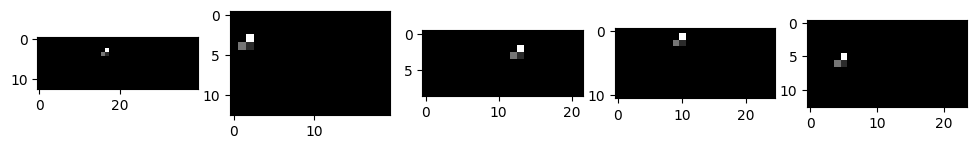

In [61]:
# Visualize the first 5 ROI's feature map (for each feature map, only show the 1st channel of d=512)
fig = plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = feature_map.narrow(0, im_idx, 1)[
        ..., roi[2] : (roi[4] + 1), roi[1] : (roi[3] + 1)
    ]
    tmp = im[0][0].detach().cpu().numpy()
    fig.add_subplot(1, 5, figNo)
    plt.imshow(tmp, cmap="gray")
    figNo += 1
plt.show()

In [62]:
# Reshape the tensor so that we can pass it through the feed forward layer.
k = output.view(output.size(0), -1)
print(k.shape)  # 25088 = 7*7*512

torch.Size([128, 25088])


### Send the bboxes & Features of 128 ROI samples to Detection Network to predict bbox and class


In [63]:
roi_head_classifier = nn.Sequential(
    *[nn.Linear(25088, 4096), nn.Linear(4096, 4096)]
).to(device)
cls_loc = nn.Linear(4096, 2 * 4).to(
    device
)  # (1 classes + 1 background. Each will have 4 co-ordinates)
cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()

score = nn.Linear(4096, 2).to(device)  # (1 classes + 1 background)

In [64]:
# passing the output of roi-pooling to ROI head
k = roi_head_classifier(k.to(device))
roi_cls_loc = cls_loc(k)
roi_cls_score = score(k)
print(roi_cls_loc.shape, roi_cls_score.shape)

torch.Size([128, 8]) torch.Size([128, 2])


### Calculate FastRCNN loss based on the gt bboxes and features of the 128 ROIs

In [65]:
# predicted
print(roi_cls_loc.shape)
print(roi_cls_score.shape)

# actual
print(gt_roi_locs.shape)
print(gt_roi_labels.shape)

torch.Size([128, 8])
torch.Size([128, 2])
(128, 4)
(128,)


In [66]:
# Converting ground truth to torch variable
gt_roi_loc = torch.from_numpy(gt_roi_locs)
gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long()
print(gt_roi_loc.shape, gt_roi_label.shape)

# Classification loss
roi_cls_loss = nn.functional.cross_entropy(
    roi_cls_score.cpu(), gt_roi_label.cpu(), ignore_index=-1
)
print(roi_cls_loss.shape)

torch.Size([128, 4]) torch.Size([128])
torch.Size([])


In [67]:
# Regression loss
n_sample = roi_cls_loc.shape[0]
roi_loc = roi_cls_loc.view(n_sample, -1, 4)
print(roi_loc.shape)

roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
print(roi_loc.shape)

# For Regression we use smooth L1 loss as defined in the Fast RCNN paper
pos = gt_roi_label > 0
mask = pos.unsqueeze(1).expand_as(roi_loc)
print(mask.shape)

# take those bounding boxes which have positve labels
mask_loc_preds = roi_loc[mask].view(-1, 4)
mask_loc_targets = gt_roi_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
roi_loc_loss = ((x < 1).float() * 0.5 * x**2) + ((x >= 1).float() * (x - 0.5))
print(roi_loc_loss.sum())

torch.Size([128, 2, 4])
torch.Size([128, 4])
torch.Size([128, 4])
torch.Size([11, 4]) torch.Size([11, 4])
tensor(117.1829, dtype=torch.float64, grad_fn=<SumBackward0>)


In [68]:
roi_lambda = 10.0
roi_loss = roi_cls_loss + (roi_lambda * roi_loc_loss)
print(roi_loss)

tensor([[ 24.2849,  23.7301,   9.0838,  20.4070],
        [  1.2695,  22.4078,  25.9118,   0.7004],
        [  6.4119,  21.9446,  14.5840,  21.8643],
        [ 15.7010,   0.6926,   2.1981,  16.8719],
        [ 50.3429,  48.2117,  36.7402,   0.9829],
        [ 69.0455, 113.8239,  46.1733,   3.5917],
        [ 43.5046,  61.1142,  65.8850,   1.5495],
        [ 24.6513,   6.4444,  28.7076,  44.8556],
        [  0.6912,  21.0925,  19.0031,  36.3839],
        [ 25.8693,  57.2987,  50.1379,  37.3519],
        [ 31.1782,   0.8279,  14.9319,  33.7877]], dtype=torch.float64,
       grad_fn=<AddBackward0>)


In [69]:
total_loss = rpn_loss.to(device) + roi_loss.to(device)
print(total_loss.shape)

NameError: name 'rpn_loss' is not defined

In [83]:
print(mask_loc_preds.shape, pos.shape, mask_loc_targets.shape)

torch.Size([11, 4]) torch.Size([128]) torch.Size([11, 4])


In [80]:
labels = gt_roi_label[gt_roi_label == 1]

In [81]:
labels.shape

torch.Size([11])